## Collection of terrible Graphs.
Graphs are plots of model based dyna implementation, without any annotations bedcause I am lazy.


In [1]:
import jax
import matplotlib.pyplot as plt

from base_rl.higher_order import make_train, CONFIG
from base_rl.models import ActorCritic
from dyna.training import make_dyna_train_fn 
from model_based.transition_models import CatchModel, CatchEquiModel_
from model_based.nn_model import NNCatch
from model_based.sample_env import make_expert_experience_fn, make_experience_fn, SARSDTuple
import model_based.train as mbt
from dyna.types import ActorCriticHyperParams, DynaHyperParams, TransitionModelHyperParams 
import numpy as np
import jax.numpy as jnp
import matplotlib

from gymnax.environments.bsuite.catch import Catch

matplotlib.rcParams.update({'text.usetex': True, "font.family": "serif"})


# Train Expert  Transition Models:

In [2]:
CONFIG_CATCH = CONFIG
CONFIG_CATCH["ENV"] = Catch()
CONFIG_CATCH["ENV_PARAMS"]=Catch().default_params
rng = jax.random.PRNGKey(42)
expert = jax.jit(make_train(CONFIG_CATCH, ActorCritic) )(rng)
ENV_NAME = "Catch-bsuite"
EXP_TOTAL = 1e6
NUM_PARALLEL = 2000

train_state = expert["runner_state"][0]


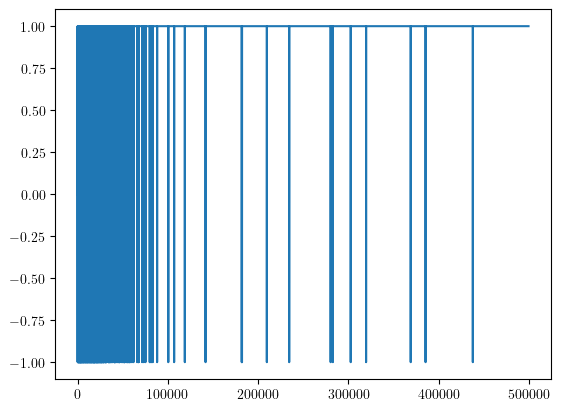

In [3]:
metrics = expert["metrics"]
returns = metrics[0]["returned_episode_returns"].reshape(-1)
plt.plot(returns)

In [4]:

expert_model_params = train_state.params
rng = jax.random.split(rng, NUM_PARALLEL)

random_experienc_fn = make_experience_fn(ENV_NAME, EXP_TOTAL//2 // NUM_PARALLEL)
expert_experience_fn = make_expert_experience_fn(ENV_NAME, EXP_TOTAL//2 //NUM_PARALLEL, expert_model_params)

random_experience = jax.vmap(random_experienc_fn)(rng)
expert_experience = jax.vmap(expert_experience_fn)(rng)

def flatten_shuff(rng, experience: SARSDTuple):
    _len= np.prod(experience.reward.shape)
    flat = jax.tree_map(lambda x: x.reshape(_len, -1), experience)
    perm = jax.random.permutation(rng, _len)
    shuff = jax.tree_map(lambda x: x.at[perm, ...].get(),flat)
    return shuff

rng = jax.random.PRNGKey(42)
expert_experience = flatten_shuff(rng, expert_experience)
random_experience = flatten_shuff(rng, random_experience)
expert_experience = expert_experience.join(random_experience)


/home/sean/ms_mono/.venv/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:796: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


In [5]:

NUM_EPCH = 100
LR = 1e-4
def make_model(hyp):
    train_data, val_data = expert_experience.partition(hyp.get_train_size(expert_experience))
    train_fn = mbt.make_train(hyp, train_data, val_data, loss_function_ho=mbt.make_catch_bce_loss_fn, val_loss_function_ho=mbt.make_catch_accuracy_loss_fn)
    return train_fn(rng)

hyp = mbt.HyperParams(model = CatchModel, epochs=NUM_EPCH , learning_rate=LR)
equi_hyp = mbt.HyperParams(model= CatchEquiModel_ , epochs=NUM_EPCH, learning_rate=LR)


tm = make_model(hyp)
equi_tm = make_model(equi_hyp)


2023-08-25 15:42:14.862415: W external/xla/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:523] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  /usr/local/cuda-12.0
  /usr/local/cuda
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions.  For most apps, setting the environment variable XLA_FLAGS=--xla_gpu_cuda_data_dir=/path/to/cuda will work.


# Sense Check model converges.


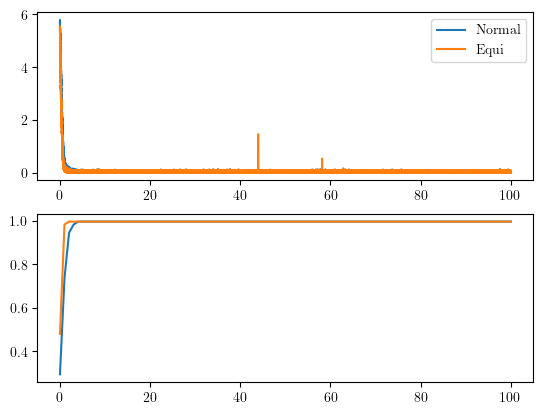

In [6]:

fig, ax = plt.subplots(2,1)
def plot_tm(ax, tm, name):
    train_loss = tm[1][0].train_loss.reshape(-1)
    val_loss = tm[1][0].val_loss.reshape(-1)
    def get_x(line, epch):
        return jnp.linspace(0, epch, num = len(line))
    ax[0].plot(get_x(train_loss, NUM_EPCH), (train_loss), label=name)

    ax[1].plot(get_x(val_loss, NUM_EPCH), val_loss)

plot_tm(ax,tm, "Normal")
plot_tm(ax, equi_tm, "Equi")
ax[0].legend()

In [7]:
NUM_UPDATES =40 
TM_LR = 1
AC_LR = 3.5e-4
NUM_SEEDS = 80 
NUM_ENVS = 4
PR = None
NUM_SCANS = 1

ac_hyp = ActorCriticHyperParams(NUM_UPDATES=40, NUM_EPOCHS=1, LR=AC_LR, PRIV_NUM_TIMESTEPS=32)
eqi_hyp = TransitionModelHyperParams(MODEL_FN=CatchEquiModel_,LR=TM_LR, NUM_EPOCHS=0, PARAMS = equi_tm[0][1].params)
tm_hyp = TransitionModelHyperParams(MODEL_FN=CatchModel,LR=TM_LR, NUM_EPOCHS=0, PARAMS=tm[0][1].params)
no_m_hyp = TransitionModelHyperParams(USE_MODEL=False, LR=TM_LR, NUM_EPOCHS=0, )
mf_hyp = DynaHyperParams(ac_hyp, no_m_hyp, NUM_UPDATES=NUM_UPDATES, PLANNING_RATIO=PR, NUM_ENVS=NUM_ENVS)
dyna_hyp = DynaHyperParams(ac_hyp, tm_hyp, NUM_UPDATES=NUM_UPDATES, PLANNING_RATIO=PR, NUM_ENVS=NUM_ENVS )
equi_hyp = DynaHyperParams(ac_hyp, eqi_hyp,NUM_UPDATES=NUM_UPDATES, PLANNING_RATIO=PR, NUM_ENVS=NUM_ENVS)

rng = jax.random.PRNGKey(42)
rngs = jax.random.split(rng, NUM_SEEDS)
results= []
hyp = [mf_hyp, dyna_hyp, equi_hyp]
names = ['Model Free', 'Dyna', 'Equi-Dyna']
outer_results = {}
for pr in [1, 2, 4, 8]:
    results = {}
    for h, n in zip(hyp, names):
        h = h._replace(PLANNING_RATIO = pr)
        train_fn = jax.vmap(make_dyna_train_fn(h, NNCatch))
        rng_split_fn = jax.vmap(jax.random.split)
        def scan_train(rng_state, _ ):
            res = train_fn(rng_state)
            rng_state = rng_split_fn(rng_state)[:, :, -1]
            _, res_info = res
            ret_ep_ret = res_info[1].info["returned_episode_returns"]
            return rng_state, ret_ep_ret

        _, result = jax.lax.scan(
            scan_train,
            rngs,
            None,
            length=NUM_SCANS
        )
        results[n] = result
        del scan_train
        
    outer_results[pr] = results
        

1


2
4
8


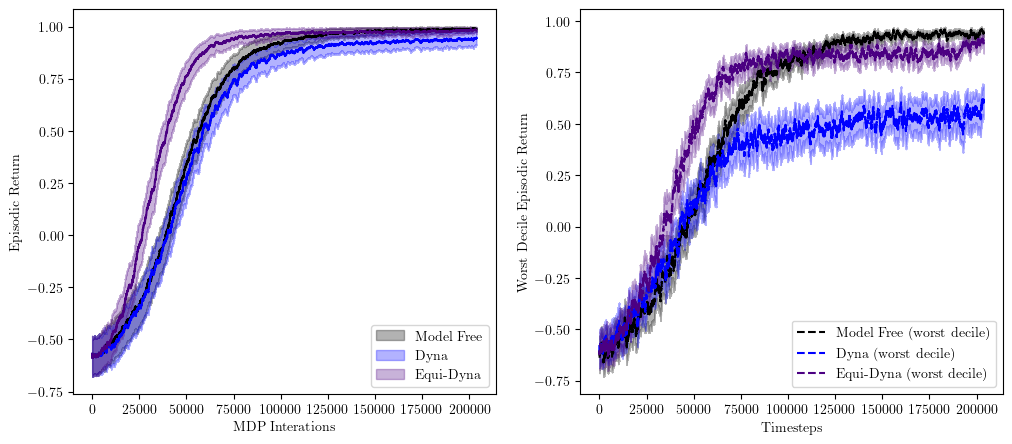

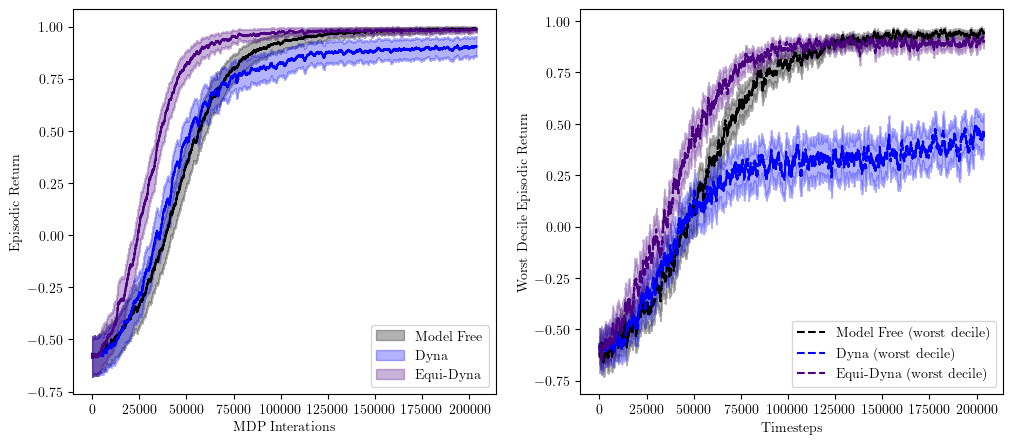

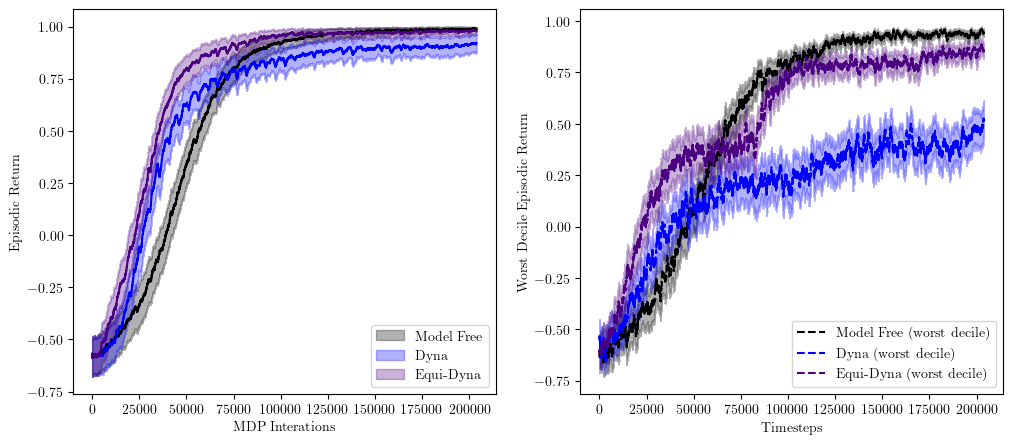

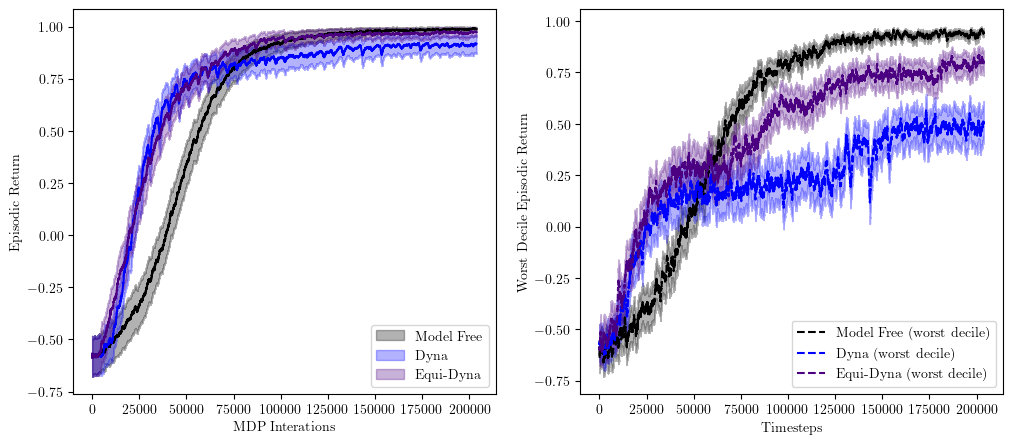

In [15]:
def moving_average(x, w=1000):
    return np.convolve(x, np.ones(w), "valid") / w

cs = ["black", "blue", "indigo"]
for pr, results in outer_results.items():
    print(pr)
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    for res, name, c in zip(results.values(), names, cs):
        acting_returns = res
        acting_returns = acting_returns.reshape(np.prod(acting_returns.shape[:2]), -1)
        acting_returns_mean = jnp.mean(acting_returns, axis=0).reshape(-1)
        acting_returns_std = jnp.std(acting_returns, axis=0).reshape(-1)/ np.sqrt(NUM_SEEDS)
        acting_returns_mean = moving_average(acting_returns_mean)
        acting_returns_std = moving_average(acting_returns_std)
        lower = acting_returns_mean - acting_returns_std
        upper = acting_returns_mean + acting_returns_std
        x = jnp.arange(len(acting_returns_mean))
        ax[0].plot(acting_returns_mean, color=c)
        ax[0].fill_between(jnp.arange(len(acting_returns_mean)), lower, upper, alpha=0.3,  label=name, color=c, )
        ax[0].legend()    
        ax[0].set_xlabel("MDP Interations")
        ax[0].set_ylabel("Episodic Return")
        cumulative_returns = np.cumsum(acting_returns, axis=1)[:, -1]
        worst_decile = np.quantile(cumulative_returns, 0.1)
        worst_mean = acting_returns[cumulative_returns < worst_decile].mean(axis=0)
        worst_std = acting_returns[cumulative_returns < worst_decile].std(
            axis=0
        ) / np.sqrt(NUM_SEEDS * NUM_SCANS)
        worst_upper = worst_mean + worst_std
        worst_lower = worst_mean - worst_std
        ax[1].plot(
            x,
            moving_average(worst_mean),
            label=f"{name} (worst decile)",
            linestyle="--",
            color=c,
        )
        ax[1].fill_between(
            x,
            moving_average(worst_lower),
            moving_average(worst_upper),
            alpha=0.3,
            color=c,
        )
        ax[1].set_xlabel("Timesteps")
        ax[1].set_ylabel("Worst Decile Episodic Return")

    ax[0].legend()
    ax[1].legend()
    fig.savefig("plots.png")




0.5825
0.608125


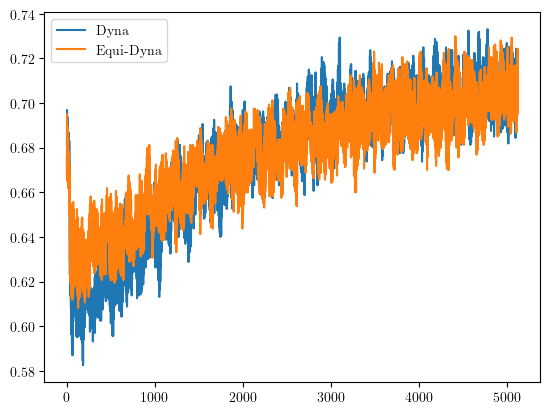

In [ ]:
for info, name in zip(results[1:], names[1:]):
    m_loss= info[-1]
    plt.plot(m_loss.mean(axis=(0, 1)).reshape(-1),  label=name)
    print(jnp.min(m_loss.mean(axis=(0, 1)).reshape(-1)))
    
plt.legend()